# **Data Augmentation**

In [2]:
import pickle,gzip,math,os,time,shutil, random
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torch
from torch import nn, distributions
from torch.nn import init
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor,optim
from torch.utils.data import DataLoader,default_collate
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

import fastcore.all as fc
from fastcore.test import test_close

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [38]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'

import logging
logging.disable(logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

set_seed(42)

if fc.defaults.cpus>8: fc.defaults.cpus=8 # since there is a ton of data augmentation in this NB

## **Setup**

In [11]:
xl, yl = 'image', 'labels'
name = "fashion_mnist"
bs = 1024
x_mean, x_std = 0.28, 0.35 # ref NB 11 initializing

@inplace
def transformi(b): b[xl]= [(TF.to_tensor(o) - x_mean)/ x_std for o in b[xl]]

dsd = load_dataset(name)
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=fc.defaults.cpus)

In [12]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
iw = partial(init_weights, leaky=0.1)

In [13]:
set_seed(42)
lr, epochs = 6e-2, 5

## **Going Wider Than Before**

The previous NB's ResNets were pretty basic and we didn't put a whole lot of thought into them. Let's attempt to make new networks which are wider than before by increasing the number of channels / filters to 512, whereas we limited the previous networks to 256.

We can do this by increasing our kernel size `ks` to 5 and changing the `stride` to 1, which will give us a 5x5 grid of 25 inputs. So we can increase the number of ouputs to 16 instead of 8. By starting with 16 outputs, and doubling with each layer, we will get 512 outputs.

In [14]:
def get_model(act=nn.ReLU, nfs=(16, 32, 64, 128, 256, 512), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1 )]
    layers += [nn.Flatten(), nn.Linear(nfs[-1], 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [15]:
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched)]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)

accuracy,loss,epoch,train
0.825,0.704,0,train
0.860,0.508,0,eval
0.898,0.380,1,train
0.884,0.373,1,eval
0.921,0.267,2,train
0.905,0.293,2,eval
0.943,0.193,3,train
0.927,0.235,3,eval
0.963,0.137,4,train
0.930,0.222,4,eval


/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


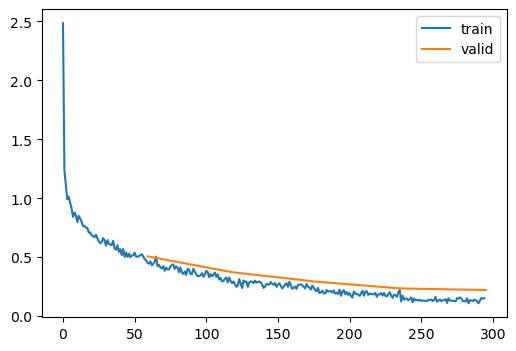

In [16]:
learn.fit(epochs)

This improves our accuracy to `93%`!

## **Pooling to Increase Flexibility**

We now need to consider model flexibility as well as depth and width. Specifically, as our models get bigger and / or the shape of our inputs changes (we won't be dealing with 28x28 images forever), we shouldn't have to constantly tinker with kernel sizes and strides just to align the outputs of the final layers so that they may pass through the Linear layer.

In [30]:
class GlobalAvgPool(nn.Module): # Keras calls this Global Avg Pooling & PyTorch calls this Adaptive Avg Pooling
    # The class takes the mean of the final layer's outputs without having to flatten the outputs.
    def forward(self, x): return x.mean((-2, -1))

In [22]:
# Creating a function to account for larger networks
def get_model2(act=nn.ReLU, nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    # Added a global / adaptive average pooling layer to the Resblock with 2x2 output.
    layers += [ResBlock(256, 512, act=act, norm=norm), GlobalAvgPool()]
    # Proceed with the Linear + Batchnorm layer
    layers += [nn.Linear(512, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

Let's alter summary patch to also show `MFLOPS`

In [32]:
def _flops(x, h, w): # Pass weight matrix plus height and width 
    if x.dim()<3 : return x.numel() # numel()==>total number of elements in the input tensor is the number of flops here
    if x.dim()==4: return x.numel()*h*w # if convolution or something similar then  multiply with h and w

@fc.patch
def summary(self:Learner): # We're approximating the MFLOPS calculation by taking the number of calculations
    res = '|Module|Input|Output|Num params|MFLOPS|\n|--|--|--|--|--|\n'
    totp, totf = 0, 0
    def _f(hook, mod, inp, outp):
        nonlocal res, totp, totf
        nparams = sum(o.numel() for o in mod.parameters())
        totp += nparams
        *_, h, w = outp.shape
        flops = sum(_flops(o, h, w) for o in mod.parameters())/1e6
        totf += flops
        res += f'|{type(mod).__name__}|{tuple(inp[0].shape)}|{tuple(outp.shape)}|{nparams}|{flops:.1f}|\n'
    with Hooks(self.model, _f) as hooks: self.fit(1, lr=1, cbs=SingleBatchCB())
    print(f"Tot params: {totp}; MFLOPS: {totf:.1f}")
    if fc.IN_NOTEBOOK:
        from IPython.display import Markdown
        return Markdown(res)
    else: print(res)

In [31]:
TrainLearner(get_model2(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 4907588; MFLOPS: 33.0


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|ResBlock|(1024, 256, 2, 2)|(1024, 512, 2, 2)|3673600|14.7|
|GlobalAvgPool|(1024, 512, 2, 2)|(1024, 512)|0|0.0|
|Linear|(1024, 512)|(1024, 10)|5120|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


Note that the penultimate layer has `stride=1` thus the outputs become 2x2 and remain 2x2 as we move from 256 to 512 channels/filters. The MFLOP count is high for the first layer due to 28x28 inputs, and higher still for the final ResBlock due to the total number of parameters coupled with the 2x2 dim.

accuracy,loss,epoch,train
0.822,0.714,0,train
0.860,0.522,0,eval
0.898,0.383,1,train
0.877,0.419,1,eval
0.920,0.270,2,train
0.904,0.289,2,eval
0.940,0.199,3,train
0.927,0.240,3,eval
0.961,0.142,4,train
0.932,0.225,4,eval


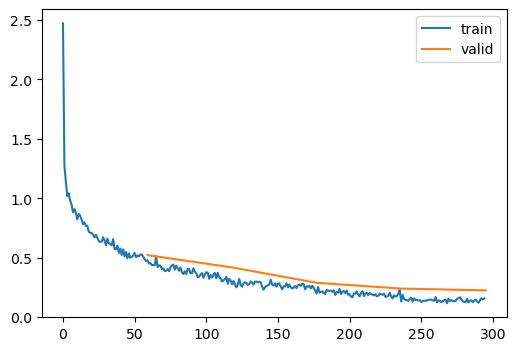

In [39]:
set_seed(42)
model = get_model2(act=act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

That takes the performance up to `93.2%`.

We can experiment further by updating the `get_model()` function by removing the line of code that takes the number of channels to 512. This will reduce the nuumber of total parameters.

In [40]:
def get_model3(act=nn.ReLU, nfs=(16, 32, 64, 128, 256), norm=nn.BatchNorm2d):
    layers = [ResBlock(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [42]:
TrainLearner(get_model3(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1231428; MFLOPS: 18.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|ResBlock|(1024, 1, 28, 28)|(1024, 16, 28, 28)|6928|5.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


In [43]:
[o.shape for o in get_model3()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 16, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 1, 1, 1]),
 torch.Size([16])]

accuracy,loss,epoch,train
0.810,0.758,0,train
0.870,0.440,0,eval
0.896,0.400,1,train
0.901,0.339,1,eval
0.919,0.276,2,train
0.904,0.299,2,eval
0.939,0.207,3,train
0.922,0.249,3,eval
0.961,0.151,4,train
0.930,0.232,4,eval


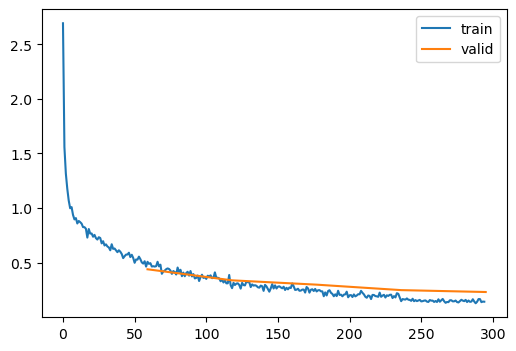

In [44]:
set_seed(42)
model = get_model3(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Interesting! We've ended up with the same performance as the previous iteration.

The next question to ask is: how can we make this faster? 

The first layer has the highest MFLOP count due to the fact that there are two convolutions taking place. One is the `16x1x5x5` convolution and the other is `16x16x5x5`. So we can reduce this to just one convolution.

In [45]:
def get_model4(act=nn.ReLU, nfs=(16,32,64,128, 256), norm=nn.BatchNorm2d):
    layers = [conv(1, 16, ks=5, stride=1, act=act, norm=norm)]
    layers += [ResBlock(nfs[i], nfs[i+1], act=act, norm=norm, stride=2) for i in range(len(nfs)-1)]
    layers += [GlobalAvgPool(), nn.Linear(256, 10, bias=False), nn.BatchNorm1d(10)]
    return nn.Sequential(*layers)

In [46]:
[o.shape for o in get_model4()[0].parameters()]

[torch.Size([16, 1, 5, 5]),
 torch.Size([16]),
 torch.Size([16]),
 torch.Size([16])]

In [47]:
TrainLearner(get_model4(), dls, F.cross_entropy, lr=lr, cbs=[DeviceCB()]).summary()

Tot params: 1224948; MFLOPS: 13.3


|Module|Input|Output|Num params|MFLOPS|
|--|--|--|--|--|
|Sequential|(1024, 1, 28, 28)|(1024, 16, 28, 28)|448|0.3|
|ResBlock|(1024, 16, 28, 28)|(1024, 32, 14, 14)|14560|2.8|
|ResBlock|(1024, 32, 14, 14)|(1024, 64, 7, 7)|57792|2.8|
|ResBlock|(1024, 64, 7, 7)|(1024, 128, 4, 4)|230272|3.7|
|ResBlock|(1024, 128, 4, 4)|(1024, 256, 2, 2)|919296|3.7|
|GlobalAvgPool|(1024, 256, 2, 2)|(1024, 256)|0|0.0|
|Linear|(1024, 256)|(1024, 10)|2560|0.0|
|BatchNorm1d|(1024, 10)|(1024, 10)|20|0.0|


By introducing this small change, we've reduced the MFLOPS by a decent amount, without dramatically impacting the total number of parameters.

accuracy,loss,epoch,train
0.803,0.782,0,train
0.871,0.476,0,eval
0.899,0.390,1,train
0.885,0.377,1,eval
0.918,0.276,2,train
0.901,0.308,2,eval
0.940,0.202,3,train
0.923,0.242,3,eval
0.962,0.149,4,train
0.926,0.235,4,eval


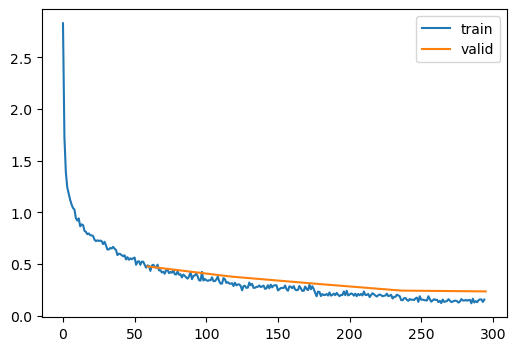

In [48]:
set_seed(42)
model = get_model4(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

Performance is almost the same as before, with a model which doesn't have the compute overhead as the larger network. Also, it still outperforms timms `resnet-18d`.

Additionally, running the model for additional epochs - say 20 - will actually decrease generalizability due to the fact that it is effectively memorizing the inputs (accuracy goes up to 99% but the validation loss actually deteriorates).

We need to regularize our data, and **since we're using batchnorm, weight decay won't do the job**. The paper titled ["L2 Regularization Versus Batch and Weight Normalization"](https://arxiv.org/abs/1706.05350) covers this in detail and basically states:

>  L2 regularization has no regularizing effect when combined with normalization. Instead, regularization has an influence on the scale of weights, and thereby on the effective learning rate.

This is where Data Augmentation comes.

## **Data Augmentation**

While FastAI has a very robust implementation of data augmentation, we will stick with PyTorch for now.

In [49]:
from torchvision import transforms

In [58]:
# Extending the functionality of the BatchTransformCB by adding a transform function
# Which transforms the inputs and outputs using two different functions
def tfm_batch(b, tfm_x=fc.noop, tfm_y=fc.noop): return tfm_x(b[0]), tfm_y(b[1])

tfms = nn.Sequential(transforms.RandomCrop(28, padding=4),
                     transforms.RandomHorizontalFlip())
# We won't run augmentations on validation sets.
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)
model = get_model()
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=[SingleBatchCB(), augcb])

The advantage of running augmentations using batches, is that the operations are running on GPU. The downside is that this reduces the amount of variety in overall transformations.

In [59]:
learn.fit(1)

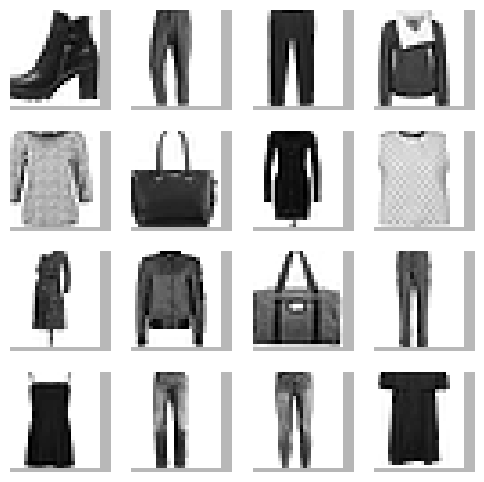

In [60]:
# Grabbing a batch from the learner.
xb, yb = learn.batch 
show_images(xb[:16], imsize=1.5)

In [62]:
@fc.patch
@fc.delegates(show_images)
def show_image_batch(self:Learner, max_n=9, cbs=None, **kwargs):
    self.fit(1, cbs=[SingleBatchCB()] + fc.L(cbs))
    show_images(self.batch[0][:max_n], **kwargs)

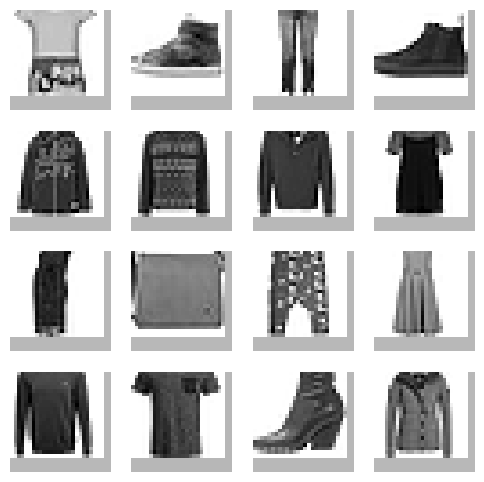

In [63]:
learn.show_image_batch(max_n=16, imsize=(1.5))

In [65]:
tfms = nn.Sequential(transforms.RandomCrop(28, padding=1),
                     transforms.RandomHorizontalFlip())
augcb = BatchTransformCB(partial(tfm_batch, tfm_x=tfms), on_val=False)

accuracy,loss,epoch,train
0.764,0.878,0,train
0.826,0.597,0,eval
0.858,0.596,1,train
0.867,0.493,1,eval
0.878,0.473,2,train
0.834,0.514,2,eval
0.886,0.395,3,train
0.858,0.420,3,eval
0.892,0.342,4,train
0.889,0.353,4,eval


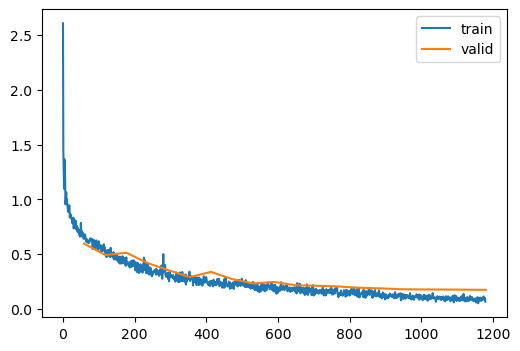

In [66]:
set_seed(42)
epochs = 20
lr = 1e-2
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
xtra = [BatchSchedCB(sched), augcb]
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = TrainLearner(model, dls, F.cross_entropy, lr=lr, cbs=cbs+xtra, opt_func=optim.AdamW)
learn.fit(epochs)

I believe the scientific term is....dayum!! `94.3%` takes us into the top 5 results for this dataset.

In [67]:
mdl_path = Path('models')
mdl_path.mkdir(exist_ok=True)
torch.save(learn.model, mdl_path/'data_aug.pkl')